# Check Reflectivity Calibration
In this example, we walk though how to check the calibration between the X-band and Ka-Band radars

## Imports

In [94]:
import pyart
import act
import glob
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
from matplotlib.dates import DateFormatter

## Download the KAZR data
We can access the Ka-band (KAZR) data from the ARM data portal

In [3]:
kazr_files = act.discovery.download_data("mgrover4",
                                         "###############",
                                         "guckazrcfrcorgeM1.c0", 
                                         "2022-03-14",
                                         "2022-03-14")

[DOWNLOADING] guckazrcfrcorgeM1.c0.20220314.000001.nc


We have glued the original xband radar files, and stored these on the local file system in the path below

In [4]:
xprecip_files = sorted(glob.glob("/gpfs/wolf/atm124/proj-shared/sail/202203_glued/xprecipradar_guc_volume_20220314-03*"))

## Load in the Data
Let's work with the xarray datasets!

In [136]:
kazr_radar = act.io.read_netcdf(kazr_files)

# this was output from the csu-xband-snowfall-march-14-2022 notebook
xband_ds = xr.open_dataset("sail_snowfall_retrievals_march_14_2022.nc")

We also need to apply the quality flags before working with the kazr data

In [137]:
kazr_lowest_reflectivity = kazr_radar.where(kazr_radar.qc_reflectivity != 1).isel(range=2)[['reflectivity']]

## Setup Functions to Calculate Snowfall

In [72]:
def snow_rate_from_ds(ds, swe_ratio, A, B, snow_field_name="snow_z", reflectivity_field='DBZ'):
    """
    Snow rate applied to an Xarray.Dataset
    
    Takes a given Snow Water Equivilent ratio (SWE_ratio), A and B value
    for the Z-S relationship and creates a radar field similar to DBZ
    showing the radar estimated snowfall rate in mm/hr. Then the given
    SWE_ratio, A and B are stored in the radar metadata for later 
    reference.   
    """
    snow_z = ds[reflectivity_field].copy()
    
    # Convert it from dB to linear units
    z_lin = 10.0**(snow_z/10.)
    
    # Apply the Z-S relation.
    snow_z = swe_ratio * (z_lin/A)**(1./B)
    
    ds[snow_field_name] = snow_z
    
    field_attrs = {"units": "mm/hr",
                   "standard_name": "snowfall_rate",
                   "long_name":"snowfall_rate_from_z",
                   "valid_min":0,
                   "valid_max":500,
                   "swe_ratio":swe_ratio,
                   "A":A,
                   "B":B}
    
    ds[snow_field_name].attrs = field_attrs
    
    return ds

In [73]:
zs_relationship_dict = {"Wolf_and_Snider":
                        {"A": 110,
                         "B": 2},
                        "WSR_88D_High_Plains":
                        {"A": 130,
                         "B": 2},
                        "WSR_88D_Intermountain_West":
                        {"A": 40,
                         "B": 2},
                        "Matrosov et al.(2009) Braham(1990) 1":
                        {"A": 67,
                         "B": 1.28},
                         "Matrosov et al.(2009) Braham(1990) 2":
                        {"A": 114,
                         "B": 1.39},
                         "Matrosov et al.(2009) Braham(1990) 3":
                        {"A": 136,
                         "B": 1.3},
                         "Matrosov et al.(2009) Braham(1990) 4":
                        {"A": 28,
                         "B": 1.44,},
                         "Matrosov et al.(2009) Braham(1990) 5":
                        {"A": 36,
                         "B": 1.56},
                         "Matrosov et al.(2009) Braham(1990) 6":
                        {"A": 48,
                         "B": 1.45},
                       }

## Apply the Z(S) relationships
We can now apply our z-s relationships to our dataset

In [132]:
for relationship in zs_relationship_dict.keys():
    snow_rate_from_ds(kazr_lowest_reflectivity,
                      8.5,
                      zs_relationship_dict[relationship]["A"],
                      zs_relationship_dict[relationship]["B"],
                      snow_field_name=relationship,
                      reflectivity_field='reflectivity')

In [133]:
ds = kazr_lowest_reflectivity

## Calculate Accumulated Snowfall 

In [134]:
zs_fields = list(zs_relationship_dict.keys())

In [135]:
ds_resampled = ds.resample(time="1T").mean()

In [121]:
for field in zs_fields:
    ds_resampled[field].attrs["units"] = "mm/hr"
    ds_resampled = act.utils.accumulate_precip(ds_resampled, field)

## Plot a Reflectivity Comparison

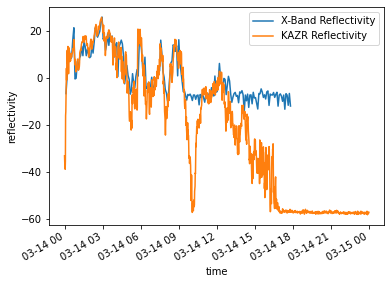

In [131]:
xband_ds.sel(site='pluvio').isel(height=0).DBZ.plot(label='X-Band Reflectivity')
ds_resampled.reflectivity.plot(label='KAZR Reflectivity')
plt.legend()
plt.title('')
plt.savefig("kazr_xband_ref.png", dpi=300)

## Compare Snowfall Totals with Gothic Weather Station
The observation here is from the Gothic wx site, using the liquid precipitation value from March 14, 2022 https://www.gothicwx.org/current-year-data-2022.html

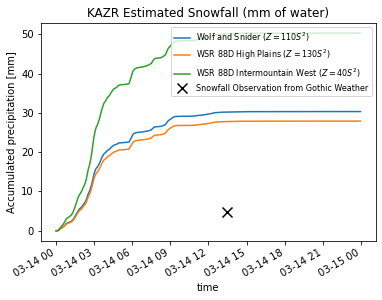

In [130]:
date_form = DateFormatter("%H%M UTC %b %d %Y")

for relationship in list(zs_relationship_dict.keys())[:3]:
    relationship_name = relationship.replace("_", " ")
    a_coefficeint = ds[relationship].A
    b_coefficeint = ds[relationship].B
    relationship_equation = f"$Z = {a_coefficeint}S^{b_coefficeint}$"

    (ds_resampled[relationship+"_accumulated"]).plot(label=f'{relationship_name} ({relationship_equation})')
    ax.xaxis.set_major_formatter(date_form)
    
plt.scatter(datetime(2022, 3, 14, 13, 30),
            4.826,
            c="k",
            s=100,
            marker="x",
            label="Snowfall Observation from Gothic Weather")
    
plt.legend(loc='upper right', fontsize=8)
plt.title("KAZR Estimated Snowfall (mm of water)")
plt.savefig("kazr_snowfall.png", dpi=300)